<a href="https://colab.research.google.com/github/akarshn95/Twitter_Sentiment_Analysis/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tweepy, json
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import re
import time
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
plt.style.use('seaborn-darkgrid')

In [2]:
# from google.colab import files
# upload = files.upload()

In [3]:
login = pd.read_csv('twitter_login.csv')

In [4]:
# Twitter API Credentials
consumerKey = login['keys'][0]
consumerSecret = login['keys'][1]
accessToken = login['keys'][2]
accessTokenSecret = login['keys'][3]

In [5]:
# create and set authentication object with access token
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
authenticate.set_access_token(accessToken, accessTokenSecret)

# create API object and pass authentication information
api = tweepy.API(authenticate, wait_on_rate_limit=True)


In [6]:
# streaming class to fetch live Tweets from Twitter API
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api=None):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open("tweets.txt", "w")
        self.start=time.time()

    def on_status(self, status):
        tweet = status._json
        self.file.write( json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        # fetch Tweets for a certain amount of time
        if(time.time()-self.start<180):
            if(self.num_tweets%500==0):
                print('Tweets Recorded: '+str(self.num_tweets))
                print('Time Elapsed: '+str(round(time.time()-self.start))+'s')
        #if self.num_tweets < 500:
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)

In [7]:
# clean tweets
def clean_tweets(tweet):
    tweet = re.sub(r'@\S+','',tweet)              #remove mentions
    tweet = re.sub(r'#','',tweet)                 #remove hashtags
    tweet = re.sub(r'RT\s+','',tweet)             #remove RT 
    tweet = re.sub(r'http\S+','',tweet)           #remove hyperlinks
    return tweet  

# calculate sentiment intensity using vader
def get_polarity(tweet):
    vader = SentimentIntensityAnalyzer()
    res=vader.polarity_scores(tweet)
    return res['compound']

# classify tweets as Positive, Negative or Neutral based on polarity
def classify_tweets(polarity):
    if polarity>0:
        return 'Positive'
    elif polarity<0:
        return 'Negative'
    else:
        return 'Neutral'

In [8]:

def sentiment_analysis(subject):
    # Initialize Stream listener
    l = MyStreamListener()

    # Create your Stream object with authentication
    stream = tweepy.Stream(authenticate, l)

    # Filter Twitter Streams to capture data by the keywords:
    stream.filter(track=[subject], languages=['en'])

    # Initialize empty list to store tweets: tweets_data
    tweets_data=[]

    # Open connection to file
    tweets_file = open('tweets.txt', "r")

    # Read in tweets and store in list: tweets_data
    for line in tweets_file:
        tweet=json.loads(line)
        tweets_data.append(tweet)

    # Close connection to file
    tweets_file.close()

    df = pd.DataFrame(tweets_data, columns=['text','lang'])
    # Clean tweets
    df['text'] = df['text'].apply(clean_tweets)


    # use TextBlob to get Subjectivity and Polarity of the Tweets on the subject
    df['polarity'] = df['text'].apply(get_polarity)

    # create a WordCloud of the Tweets about the subject
    all_words = ' '.join([tweet for tweet in df['text']])
    word_cloud = WordCloud(width=450, height=450, random_state=42, max_font_size=100, background_color='black',prefer_horizontal=0.75)

    word_cloud.generate(all_words)

    plt.figure(figsize=(5.5, 5.5),dpi=120,edgecolor='black',facecolor='black')
    plt.axis('off')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.show()

    df['sentiment'] = df['polarity'].apply(classify_tweets)
    print('\n')
    # plot bar graph of the sentiment
    plt.figure(figsize=(5, 5),dpi=100)

    plt.title('Live Twitter Sentiment: '+subject)
    sns.set_style('darkgrid')
    sns.barplot(x=df.sentiment.value_counts().index, y=df.sentiment.value_counts())
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Tweets')
    plt.show()

    return df

Tweets Recorded: 500
Time Elapsed: 11s
Tweets Recorded: 1000
Time Elapsed: 21s
Tweets Recorded: 1500
Time Elapsed: 33s
Tweets Recorded: 2000
Time Elapsed: 43s
Tweets Recorded: 2500
Time Elapsed: 54s
Tweets Recorded: 3000
Time Elapsed: 65s
Tweets Recorded: 3500
Time Elapsed: 76s
Tweets Recorded: 4000
Time Elapsed: 86s
Tweets Recorded: 4500
Time Elapsed: 96s
Tweets Recorded: 5000
Time Elapsed: 107s
Tweets Recorded: 5500
Time Elapsed: 118s
Tweets Recorded: 6000
Time Elapsed: 128s
Tweets Recorded: 6500
Time Elapsed: 140s
Tweets Recorded: 7000
Time Elapsed: 150s
Tweets Recorded: 7500
Time Elapsed: 161s
Tweets Recorded: 8000
Time Elapsed: 172s


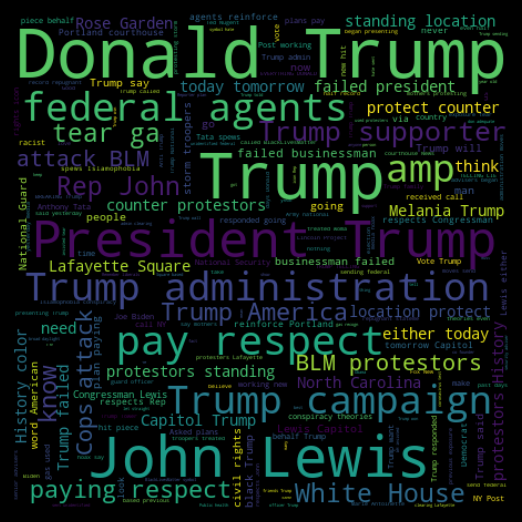

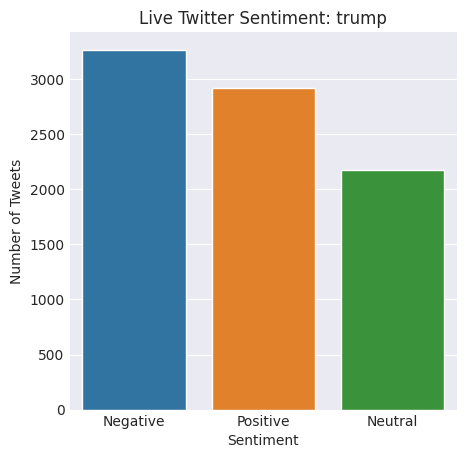

In [9]:
df= sentiment_analysis("trump")

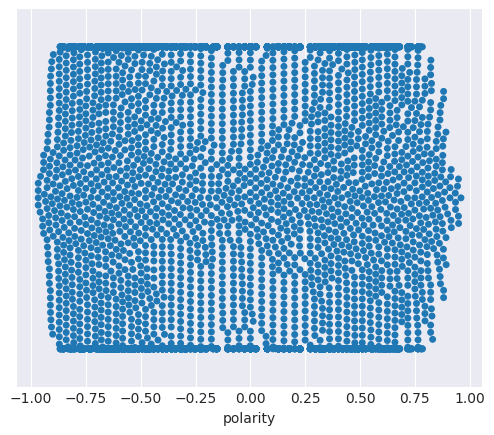

In [10]:
plt.figure(figsize=(6,5),dpi=100)
sns.swarmplot(x=df['polarity'])